In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statistics import mean
from sklearn.impute import KNNImputer
from numpy import isnan

%matplotlib inline

In [2]:
# ,encoding= 'unicode_escape'
data = pd.read_csv('D:/TMU/data/patient.csv')
print(data.shape)
# data.head()
# data.describe()
df = data

(237, 22)


In [3]:
bloodPressureArray =[]
for row in df.index:
#     print(df[df.index==row]['SBP'])
    SBP =df[df.index==row]['SBP'].values
    DBP =df[df.index==row]['DBP'].values
    if(np.isnan(SBP) or np.isnan(DBP)):
        bloodPressureArray.append("NaN")
    elif(SBP<130 and DBP<85):
        bloodPressureArray.append(0)
#     elif(120<=SBP<140 or 80<=DBP<90):
#         bloodPressureArray.append(1)  
#     elif(140<=SBP<160 or 90<=DBP<99):
#         bloodPressureArray.append(2) 
    else:
        bloodPressureArray.append(1) 
        

df.insert(1, 'BPClass', bloodPressureArray)
del df['SBP']
del df['DBP']

In [4]:
# create Blood Pressure type binding using SBP & DBP
BMIarray =[]
for row in df.index:
#     print(df[df.index==row]['SBP'])
    H =df[df.index==row]['heights'].values
    W =df[df.index==row]['weights'].values
    BMI = W / (H/100)**2
    if(np.isnan(W) or np.isnan(H)):
        BMIarray.append("NaN")
    elif BMI < 18.5:
        BMIarray.append(0)
    elif 18.5 <= BMI < 25:
        BMIarray.append(1)
    elif 25 <= BMI < 30:
        BMIarray.append(2)
    elif 30 <= BMI < 40:
        BMIarray.append(3)
    else:
        BMIarray.append(4)

df.insert(1, 'BMI', BMIarray)
del df['heights']
del df['weights']
del df['FBS']


In [5]:
df.dropna(thresh=11, inplace=True)

df.dropna(thresh=df.shape[0]*0.5,how='all',axis=1, inplace=True)

X_impute= df.drop(['id'],axis=1)

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit on the dataset
imputer.fit(X_impute)
# transform the dataset
Xtrans = imputer.transform(X_impute)
# print total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))
df=pd.DataFrame(np.round(Xtrans) ,columns = X_impute.columns)


Missing: 0


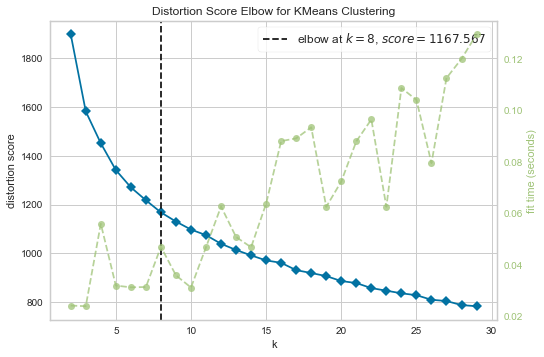

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(df)        # Fit data to visualizer
visualizer.show() 

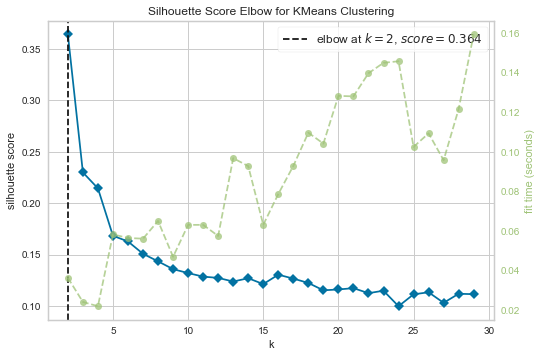

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
# Silhouette Score for K means
model_Silhouette = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model_Silhouette, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df)
visualizer.show()

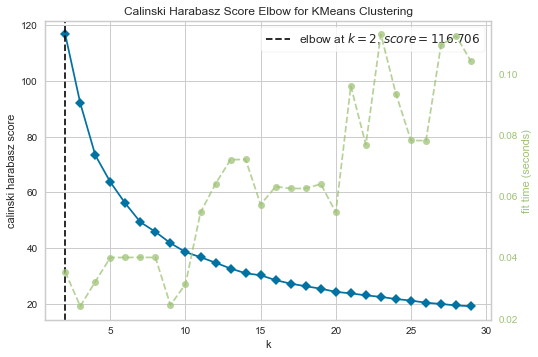

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
# Calinski-Harabasz Index
# Higher the Calinski-Harabasz Index value, better the clustering model
# based on the idea that clusters that are (1) themselves very compact and (2) well-spaced from each other are good clusters. 
model_Calinski = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model_Calinski, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df)        
visualizer.show()

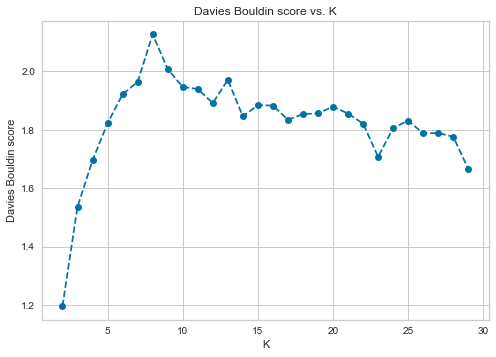

In [9]:
# Davies-Bouldin Index
# as DB index falls, the clustering improves.
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


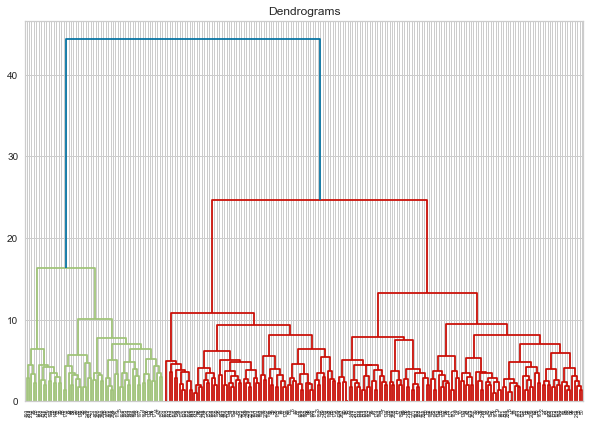

In [10]:
# Dendrogram
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

In [11]:
# Bayesian information criterion
# The lower the BIC score, better is the model. 
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(df)
        score.append((cov,n_comp,gmm.bic(df)))
sorted(score, key=lambda row: row[2]) 

[('diag', 29, -3550.6676842727293),
 ('diag', 20, -3496.6869718620997),
 ('diag', 28, -3380.3523851385044),
 ('diag', 23, -3096.9187250344885),
 ('diag', 26, -3070.960878703664),
 ('diag', 27, -3062.3207209638795),
 ('diag', 22, -2796.3686921098342),
 ('diag', 17, -2729.101649318058),
 ('diag', 25, -2674.459810211004),
 ('diag', 24, -2583.936089254037),
 ('diag', 21, -2332.8820803847616),
 ('diag', 18, -2156.1252392016477),
 ('diag', 15, -2060.1684676559535),
 ('diag', 14, -1667.8668150160865),
 ('diag', 16, -1598.2826280735048),
 ('diag', 19, -1259.5664869719212),
 ('diag', 12, -1047.5840685560952),
 ('diag', 9, -924.2428842431084),
 ('diag', 13, -799.8390806320012),
 ('diag', 10, 376.1646571878164),
 ('diag', 11, 489.1312616797509),
 ('diag', 8, 997.7764140790002),
 ('diag', 7, 1689.2060191997389),
 ('diag', 5, 1708.1923442881443),
 ('diag', 6, 2853.6271731040165),
 ('diag', 4, 3784.6768341121415),
 ('diag', 3, 4400.040970768171),
 ('diag', 2, 5461.292037199284),
 ('full', 23, 6091.5